# Benchmarking

In [2]:
import numpy as np
import xarray as xr
from scipy import stats
import pandas as pd
import numba as nb
import dask
import dask.array as da
import dask.bag as db
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import functools
from netCDF4 import Dataset

# xarray Dataset

In [2]:
path_gdp = '../data/process/gdp_v2.00.nc'

rowsize = Dataset(path_gdp)['rowsize'][:].data
ds = xr.open_dataset(path_gdp, chunks={}) # chunks={} to automatically select chunks size
chunks_settings = {'obs': tuple(rowsize.tolist())}

In [3]:
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ID                     (traj) int64 dask.array<chunksize=(17324,), meta=np.ndarray>
    longitude              (obs) float32 dask.array<chunksize=(165754333,), meta=np.ndarray>
    latitude               (obs) float32 dask.array<chunksize=(165754333,), meta=np.ndarray>
    time                   (obs) datetime64[ns] dask.array<chunksize=(165754333,), meta=np.ndarray>
    ids                    (obs) int64 dask.array<chunksize=(165754333,), meta=np.ndarray>
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 dask.array<chunksize=(17324,), meta=np.ndarray>
    location_type          (traj) bool dask.array<chunksize=(17324,), meta=np.ndarray>
    WMO                    (traj) int32 dask.array<chunksize=(17324,), meta=np.ndarray>
    expno                  (traj) int32 dask.array<chunksize=(17324,), meta=np.ndarray>
    deploy_date            (traj) datetime64[ns] dask.array<chunksize=(17324,), meta=np.ndarray>
    deploy_lon             (traj) float32 dask.array<chunksize=(17324,), meta=np.ndarray>
    ...                     ...
    err_sst                (obs) float32 dask.array<chunksize=(165754333,), meta=np.ndarray>
    err_sst1               (obs) float32 dask.array<chunksize=(165754333,), meta=np.ndarray>
    err_sst2               (obs) float32 dask.array<chunksize=(165754333,), meta=np.ndarray>
    flg_sst                (obs) int8 dask.array<chunksize=(165754333,), meta=np.ndarray>
    flg_sst1               (obs) int8 dask.array<chunksize=(165754333,), meta=np.ndarray>
    flg_sst2               (obs) int8 dask.array<chunksize=(165754333,), meta=np.ndarray>
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-02-02T15:57:04.179158
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

## Geographical binning of any variable

In [4]:
%%time

lon = np.linspace(-180, 180, 360*2)
lat = np.linspace(-90, 90, 180*2)

ret = stats.binned_statistic_2d(ds.longitude, 
                                ds.latitude, 
                                0.5*np.sqrt(np.power(ds.ve, 2) + np.power(ds.vn, 2)), # KE
                                statistic=np.nanmean, 
                                bins=[lon, lat])

CPU times: user 1min 5s, sys: 6.96 s, total: 1min 12s
Wall time: 1min 15s


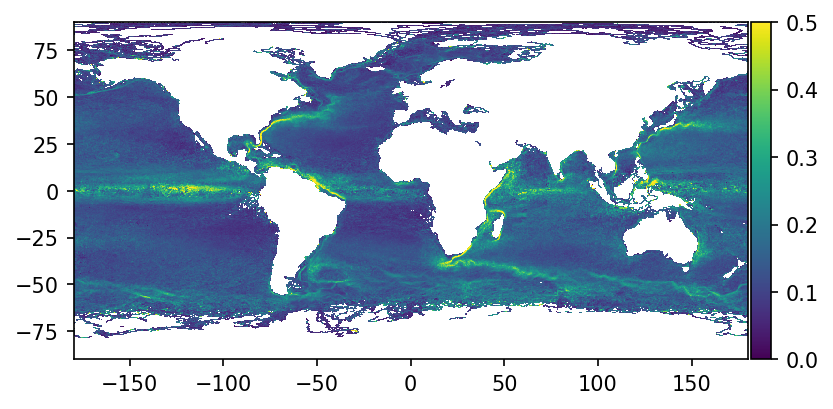

In [5]:
x_c = np.convolve(lon, [0.5, 0.5], mode='valid')
y_c = np.convolve(lat, [0.5, 0.5], mode='valid')

fig = plt.figure(dpi=150)
ax = fig.add_subplot(1,1,1,aspect='equal')
pcm = ax.pcolormesh(x_c, y_c, ret.statistic.T, vmin=0, vmax=0.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
fig.colorbar(pcm, cax=cax);

## Extracting a given region

In [6]:
def retrieve_region(ds, lon: list = None, lat: list = None, time: list = None):
    '''

    :param lon:
    :param lat:
    :param time:
    :return:
    '''
    mask = np.ones(ds.dims['obs'], dtype='bool')

    if lon:  # TODO: deal with ranges across dateline
        mask &= (ds.coords['longitude'] >= lon[0]).values
        mask &= (ds.coords['longitude'] <= lon[1]).values

    if lat:
        mask &= (ds.coords['latitude'] >= lat[0]).values
        mask &= (ds.coords['latitude'] <= lat[1]).values

    if time:
        mask &= (ds.coords['time'] >= np.datetime64(time[0])).values
        mask &= (ds.coords['time'] <= np.datetime64(time[1])).values

    mask_id = np.in1d(ds.ID, np.unique(ds.ids[mask]))
    ds_subset = ds.isel(obs=np.where(mask)[0], traj=np.where(mask_id)[0])

    return ds_subset.compute(), mask

In [7]:
%%time

lon = [-98, -78]
lat = [18, 31]
day0 = "%sZ" % datetime(2015,1,1).isoformat()
day1 = "%sZ" % datetime(2020,12,31).isoformat()
time = [day0, day1]
ds_subset, m = retrieve_region(ds, lon, lat, time)

/var/folders/jh/92r7zqw159xbv25hk5fbrzgw0000gp/T/ipykernel_64603/2976316536.py:20: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  mask &= (ds.coords['time'] >= np.datetime64(time[0])).values
/var/folders/jh/92r7zqw159xbv25hk5fbrzgw0000gp/T/ipykernel_64603/2976316536.py:21: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  mask &= (ds.coords['time'] <= np.datetime64(time[1])).values


CPU times: user 6.62 s, sys: 9.81 s, total: 16.4 s
Wall time: 19 s


In [32]:
ds_subset

<xarray.Dataset>
Dimensions:                (traj: 202, obs: 316141)
Coordinates:
    ID                     (traj) int64 102539 102541 102542 ... 39629 89907
    longitude              (obs) float32 -87.51 -87.48 -87.44 ... -81.62 -81.6
    latitude               (obs) float32 29.42 29.42 29.41 ... 24.36 24.37 24.37
    time                   (obs) datetime64[ns] 2016-01-22T15:00:00 ... 2015-...
    ids                    (obs) int64 102539 102539 102539 ... 89907 89907
Dimensions without coordinates: traj, obs
Data variables: (12/54)
    rowsize                (traj) int64 1684 240 93 1460 ... 613 779 3835 92
    location_type          (traj) bool False False False ... False False False
    WMO                    (traj) int32 4200514 4300563 ... 4300570 6300547
    expno                  (traj) int32 5325 5325 5325 5325 ... 8325 8325 9325
    deploy_date            (traj) datetime64[ns] 2016-01-21 ... 2015-06-23
    deploy_lon             (traj) float32 -87.67 -83.68 -83.15 ... -88.42 -83.1
    ...                     ...
    err_sst                (obs) float32 0.051 0.049 0.049 ... 0.041 0.041 nan
    err_sst1               (obs) float32 0.121 0.083 0.059 ... 0.079 0.115 nan
    err_sst2               (obs) float32 0.124 0.104 0.083 ... 0.097 0.112 nan
    flg_sst                (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 0
    flg_sst1               (obs) int8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 0
    flg_sst2               (obs) int8 5 5 5 5 2 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 0
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-02-02T15:57:04.179158
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

## Single statistics per trajectory

In [33]:
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

In [34]:
# we can retrive the data of a trajectory with isel
i = 1000
ds.isel({'obs': slice(traj_idx[i], traj_idx[i+1]), 'traj': i})

<xarray.Dataset>
Dimensions:                (obs: 23601)
Coordinates:
    ID                     int64 dask.array<chunksize=(), meta=np.ndarray>
    longitude              (obs) float32 dask.array<chunksize=(23601,), meta=np.ndarray>
    latitude               (obs) float32 dask.array<chunksize=(23601,), meta=np.ndarray>
    time                   (obs) datetime64[ns] dask.array<chunksize=(23601,), meta=np.ndarray>
    ids                    (obs) int64 dask.array<chunksize=(23601,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables: (12/55)
    rowsize                int64 dask.array<chunksize=(), meta=np.ndarray>
    location_type          bool dask.array<chunksize=(), meta=np.ndarray>
    WMO                    int32 dask.array<chunksize=(), meta=np.ndarray>
    expno                  int32 dask.array<chunksize=(), meta=np.ndarray>
    deploy_date            datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    deploy_lon             float32 dask.array<chunksize=(), meta=np.ndarray>
    ...                     ...
    err_sst1               (obs) float32 dask.array<chunksize=(23601,), meta=np.ndarray>
    err_sst2               (obs) float32 dask.array<chunksize=(23601,), meta=np.ndarray>
    flg_sst                (obs) int8 dask.array<chunksize=(23601,), meta=np.ndarray>
    flg_sst1               (obs) int8 dask.array<chunksize=(23601,), meta=np.ndarray>
    flg_sst2               (obs) int8 dask.array<chunksize=(23601,), meta=np.ndarray>
    cmp_uv                 (obs) complex64 dask.array<chunksize=(23601,), meta=np.ndarray>
Attributes: (12/15)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-02-02T15:57:04.179158
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot et al. (2022) to be submitted. Elipot et al. (2...
    summary:           Global Drifter Program hourly data

In [35]:
# and perform mean() on a set of variables
s_var = ['ve', 'vn', 'gap', 'err_lat', 'err_lon', 'sst', 'sst1', 'sst2', 'err_sst', 'err_sst1', 'err_sst2']
ds.isel({'obs': slice(traj_idx[i], traj_idx[i+1]), 'traj': i})[s_var].mean().compute()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    ID        int64 114578
Data variables:
    ve        float32 -0.05506
    vn        float32 -0.03076
    gap       float32 7.982e+03
    err_lat   float32 0.003078
    err_lon   float32 0.004307
    sst       float32 298.5
    sst1      float32 298.5
    sst2      float32 0.002437
    err_sst   float32 0.03603
    err_sst1  float32 0.0122
    err_sst2  float32 0.03238

## for loop (not recommended!)
- because the dataset is split into chunks, this potentially requires to load multiple chunks per iteration

In [12]:
# takes 8-9min
"""
%%time

stats_traj = np.zeros(ds.dims['traj'])
for i in range(0, ds.dims['traj']):
    stats_traj[i] = np.nanmean(ds.sst[traj_idx[i]:traj_idx[i+1]])
"""

"\n%%time\n\nstats_traj = np.zeros(ds.dims['traj'])\nfor i in range(0, ds.dims['traj']):\n    stats_traj[i] = np.nanmean(ds.sst[traj_idx[i]:traj_idx[i+1]])\n"

### loop are much (much) faster if we preload the variable before

In [36]:
sst = ds.sst.values # now sst is in memory as a numpy array

In [37]:
%%time

stats_traj = np.zeros(ds.dims['traj'])
for i in range(0, ds.dims['traj']):
    stats_traj[i] = np.nanmean(sst[traj_idx[i]:traj_idx[i+1]])

<timed exec>:3: RuntimeWarning: Mean of empty slice


CPU times: user 547 ms, sys: 237 ms, total: 784 ms
Wall time: 829 ms


In [38]:
stats_traj

array([292.91833496, 294.80477905, 301.4838562 , ..., 277.73733521,
       279.47192383, 282.17581177])

In [39]:
del sst # clear from memory

## or loading the dataset by chunk of trajectory automatically

In [40]:
rowsize = ds.rowsize.values
ds.close()
path_gdp = '../data/process/gdp_v2.00.nc'

# now each chunk is aligned with the trajectories
chunk_settings = {'obs': tuple(rowsize.tolist())}
ds = xr.open_dataset(path_gdp, chunks=chunk_settings)

In [41]:
# here we can see that the variables are splitted into 17324 Chunks (with a maximum size of 66417)
ds.longitude

<xarray.DataArray 'longitude' (obs: 165754333)>
dask.array<open_dataset-e8e7539eaeaf501ba48385402f69cd47longitude, shape=(165754333,), dtype=float32, chunksize=(66417,), chunktype=numpy.ndarray>
Coordinates:
    longitude  (obs) float32 dask.array<chunksize=(417,), meta=np.ndarray>
    latitude   (obs) float32 dask.array<chunksize=(417,), meta=np.ndarray>
    time       (obs) datetime64[ns] dask.array<chunksize=(417,), meta=np.ndarray>
    ids        (obs) int64 dask.array<chunksize=(417,), meta=np.ndarray>
Dimensions without coordinates: obs
Attributes:
    long_name:  Longitude
    units:      degrees_east

In [19]:
# and loading one variable for a trajectory only requires 1 chunk
i = 5252
ds.longitude.isel({'obs': slice(traj_idx[i], traj_idx[i+1])})

<xarray.DataArray 'longitude' (obs: 1093)>
dask.array<getitem, shape=(1093,), dtype=float32, chunksize=(1093,), chunktype=numpy.ndarray>
Coordinates:
    longitude  (obs) float32 dask.array<chunksize=(1093,), meta=np.ndarray>
    latitude   (obs) float32 dask.array<chunksize=(1093,), meta=np.ndarray>
    time       (obs) datetime64[ns] dask.array<chunksize=(1093,), meta=np.ndarray>
    ids        (obs) int64 dask.array<chunksize=(1093,), meta=np.ndarray>
Dimensions without coordinates: obs
Attributes:
    long_name:  Longitude
    units:      degrees_east

### can apply function to variable by chunks with `map_blocks` or `ufunc`

In [42]:
%%time

def func(x):
    return np.array([np.nanmean(x), np.nanmin(x), np.nanmax(x)])

stats_traj = ds.ve.data.map_blocks(func).compute()

assert(len(stats_traj) == 3 * ds.dims['traj']) # three times the traj

CPU times: user 4.26 s, sys: 1.18 s, total: 5.44 s
Wall time: 4.02 s


In [43]:
stats_traj

array([ 0.05867722, -0.2676    ,  0.3621    , ..., -0.02242104,
       -0.7521    ,  0.6449    ], dtype=float32)

## The `apply_ufunc` is applied by block. It is not easy to visualize with this dataset but see the following for example.

In [3]:
dt = xr.Dataset(
    data_vars=dict(
        value=(["x"], [1,1,2,2,2,3,3,3,3,3]), 
    ),
    coords=dict(
        lon=(["x"], np.linspace(0,1,10)),
    ),
).chunk(chunks={'x': tuple([2,3,5])}) # three chunks of different size

`apply_ufunc` can also be used when the input and output have different size, but require a bit more work
 the documentation is limited but there is this [example](https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html).

In [12]:
%%time

def per_chunk_fft(array):
    return array.map_blocks(lambda x: np.fft.fft(x), chunks=array.chunks)

xr.apply_ufunc(
    per_chunk_fft,
    dt.value + dt.value*1j,
    input_core_dims=[["x"]],  # input dimension to the per_block function
    output_core_dims=[["x"]],  # output still has one dimension
    dask='allowed'
).compute()

CPU times: user 7.3 ms, sys: 1.07 ms, total: 8.37 ms
Wall time: 7.66 ms


<xarray.DataArray 'value' (x: 10)>
array([ 2. +2.j,  0. +0.j,  6. +6.j,  0. +0.j,  0. +0.j, 15.+15.j,
        0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j])
Coordinates:
    lon      (x) float64 0.0 0.1111 0.2222 0.3333 ... 0.6667 0.7778 0.8889 1.0
Dimensions without coordinates: x

In [4]:
def per_block_mean(array):
    assert array.ndim == 1
    nchunks = len(array.chunks[0])
    output_chunks = ([1] * nchunks,) # 1 value per chunk
    # mapped function MUST return an array (https://github.com/dask/dask/issues/8822)
    return array.map_blocks(lambda x: np.mean(x, keepdims=True), chunks=output_chunks)

In [5]:
xr.apply_ufunc(
    per_block_mean,
    dt,
    input_core_dims=[["x"]],  # input dimension to the per_block function
    output_core_dims=[["x"]],  # output still has one dimension
    exclude_dims=set("x"),  # size of x changes so it has to be in the exclude_dims param
    dask="allowed",
).compute()

<xarray.Dataset>
Dimensions:  (x: 3)
Dimensions without coordinates: x
Data variables:
    value    (x) float64 1.0 2.0 3.0

In [6]:
def func(array):
    nchunks = len(array.chunks[0])
    print(nchunks)
    return array.map_blocks(lambda x: x-np.mean(x), chunks=array.chunks)

In [7]:
xr.apply_ufunc(
    func,
    dt,
    input_core_dims=[['x']],
    output_core_dims=[['x']],
    dask='allowed'
).compute()

3


<xarray.Dataset>
Dimensions:  (x: 10)
Coordinates:
    lon      (x) float64 0.0 0.1111 0.2222 0.3333 ... 0.6667 0.7778 0.8889 1.0
Dimensions without coordinates: x
Data variables:
    value    (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

## Frequency Rotary Spectra

In [8]:
ds['cmp_uv'] = ds.ve + ds.vn*1j

NameError: name 'ds' is not defined

In [47]:
ds['cmp_uv']

<xarray.DataArray 'cmp_uv' (obs: 165754333)>
dask.array<add, shape=(165754333,), dtype=complex64, chunksize=(66417,), chunktype=numpy.ndarray>
Coordinates:
    longitude  (obs) float32 dask.array<chunksize=(417,), meta=np.ndarray>
    latitude   (obs) float32 dask.array<chunksize=(417,), meta=np.ndarray>
    time       (obs) datetime64[ns] dask.array<chunksize=(417,), meta=np.ndarray>
    ids        (obs) int64 dask.array<chunksize=(417,), meta=np.ndarray>
Dimensions without coordinates: obs

In [50]:
def per_chunk_fft(array):
    nchunks = len(array.chunks[0])
    return array.map_blocks(lambda x: np.fft.fft(x), chunks=array.chunks)

In [51]:
%%time
xr.apply_ufunc(
    per_chunk_fft,
    ds['cmp_uv'],
    input_core_dims=[["obs"]],  # input dimension to the per_block function
    output_core_dims=[["obs"]],  # output still has one dimension
    dask='allowed'
).compute()

CPU times: user 26.4 s, sys: 10.1 s, total: 36.6 s
Wall time: 39.6 s


<xarray.DataArray 'cmp_uv' (obs: 165754333)>
array([ 24.46840008+18.70980014j,  37.57112095 +1.47150771j,
        23.8163065  -0.69824325j, ..., -28.21330646 -8.76757567j,
       -30.42217431 -5.0045694j , -19.64997094+29.92176195j])
Coordinates:
    longitude  (obs) float32 -17.74 -17.75 -17.74 ... -30.27 -30.32 -30.37
    latitude   (obs) float32 14.75 14.76 14.77 14.78 ... 66.82 66.82 66.81 66.8
    time       (obs) datetime64[ns] 2012-03-15T22:00:00 ... 1999-10-26T14:00:00
    ids        (obs) int64 101143 101143 101143 ... 9929870 9929870 9929870
Dimensions without coordinates: obs

### can always preload one vector

In [24]:
sig = ds['cmp_uv'].values

In [25]:
sig.nbytes / 1024**3 # size in GB

1.234966017305851

In [26]:
%%time
fft_sig = np.zeros(ds.dims['traj'], dtype='object')
for i in range(0, ds.dims['traj']): # simple loop
    fft_sig[i] = np.fft.fft(sig[traj_idx[i]:traj_idx[i+1]])

CPU times: user 7.63 s, sys: 1.08 s, total: 8.71 s
Wall time: 9.31 s
